In [3]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/imports.ipynb")

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


Create the data

In [ ]:
for class_label in ['class_i', 'class_ii']:
    patient_affinities = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.{0}.csv'.format(class_label),
                                     index_col=0)
    patient_mutations = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_mutations.csv',
                                     index_col=0)
    fem = [x for x in df[df.gender == 'FEMALE'].index if x in patient_affinities.index]
    mal = [x for x in df[df.gender == 'MALE'].index if x in patient_affinities.index]
    print len(fem), len(mal)
    out = '/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/'
    patient_affinities.ix[mal].to_csv(out + 'patient_affinities.{0}.male.csv'.format(class_label))
    patient_affinities.ix[fem].to_csv(out + 'patient_affinities.{0}.female.csv'.format(class_label))

    patient_mutations.ix[mal].to_csv(out + 'patient_mutations.{0}.male.csv'.format(class_label))
    patient_mutations.ix[fem].to_csv(out + 'patient_mutations.{0}.female.csv'.format(class_label))

Run on cluster

In [ ]:
def create_cluster_script(thresholds, models, tissue_fs, mut_fs, aff1_fs, aff2_fs, names, pans):
    
    new_script_file = '/cellar/users/ramarty/Projects/hla_ii/data_analysis/patient_selection/OR.gender.sh'
    
    with open(new_script_file, 'w') as out_file:
        out_file.write("#! /bin/csh\n")
        out_file.write("#$ -V\n")
        out_file.write("#$ -S /bin/csh\n")
        out_file.write("#$ -o /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -e /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -cwd\n")
        #out_file.write("#$ -t 1-4\n".format(len(thresholds)))
        out_file.write("#$ -t 1-{0}\n".format(len(thresholds)))
        out_file.write("#$ -l h_vmem=30G\n")
        out_file.write("#$ -tc 100\n")
        out_file.write("#$ -l long")
        out_file.write("\n")

        out_file.write("set thresholds=({0})\n".format(" ".join(thresholds)))
        out_file.write("set models=({0})\n".format(" ".join(models)))
        out_file.write("set tissue_fs=({0})\n".format(" ".join(tissue_fs)))
        out_file.write("set mut_fs=({0})\n".format(" ".join(mut_fs)))
        out_file.write("set aff1_fs=({0})\n".format(" ".join(aff1_fs)))
        out_file.write("set aff2_fs=({0})\n".format(" ".join(aff2_fs)))
        out_file.write("set names=({0})\n".format(" ".join(names)))
        out_file.write("set pans=({0})\n".format(" ".join(pans)))
        out_file.write("\n")

        out_file.write("set threshold=$thresholds[$SGE_TASK_ID]\n")
        out_file.write("set model=$models[$SGE_TASK_ID]\n")
        out_file.write("set tissue_f=$tissue_fs[$SGE_TASK_ID]\n")
        out_file.write("set mut_f=$mut_fs[$SGE_TASK_ID]\n")
        out_file.write("set aff1_f=$aff1_fs[$SGE_TASK_ID]\n")
        out_file.write("set aff2_f=$aff2_fs[$SGE_TASK_ID]\n")
        out_file.write("set name=$names[$SGE_TASK_ID]\n")
        out_file.write("set pan=$pans[$SGE_TASK_ID]\n")
        out_file.write("\n")
        
        out_file.write("date\n")
        out_file.write("hostname\n")
        out_file.write("\n")
  
        out_file.write("Rscript --vanilla /cellar/users/ramarty/Projects/hla_ii/data_analysis/patient_selection/OR.R $threshold $model $tissue_f $mut_f $aff1_f $aff2_f $name $pan\n")
        out_file.write("\n")
                       
        out_file.write("date\n")

In [ ]:
# first MHC-II only (driver, passenger, germline); then both (driver, passenger, germline)
class_label = 'class_i'
models = ['0']*2
pans = ['0']*2
thresholds = ['2']*2
tissue_fs = ['patient_tissues.csv']*8
mut_fs = ['combined_classes/patient_mutations.{0}.male.csv'.format(class_label),
           'combined_classes/patient_mutations.{0}.female.csv'.format(class_label)]*2
aff1_fs = ['combined_classes/patient_affinities.{0}.male.csv'.format(class_label),
           'combined_classes/patient_affinities.{0}.female.csv'.format(class_label)]*2
# these are never referenced
aff2_fs = (['patient_affinities.cancer.all.csv', 'patient_affinities.passenger.csv'])*2
names = ['{0}.male'.format(class_label), 
         '{0}.female'.format(class_label)]*2

create_cluster_script(thresholds, models, tissue_fs, mut_fs, aff1_fs, aff2_fs, names, pans)

Compile results

In [4]:
# pan

MI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.class_i.male.txt',
           sep= ' ')
FI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.class_i.female.txt',
           sep= ' ')
MI['Class'] = 'I'
FI['Class'] = 'I'
MI['Gender'] = 'Male'
FI['Gender'] = 'Female'

MII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.class_ii.male.txt',
           sep= ' ')
FII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.class_ii.female.txt',
           sep= ' ')
MII['Class'] = 'II'
FII['Class'] = 'II'
MII['Gender'] = 'Male'
FII['Gender'] = 'Female'

pan = pd.concat([MI, FI, MII, FII])
pan = pan.ix['mutation']

In [5]:
pan.to_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/gender/pan.csv',index=None)

In [6]:
# tissue

FI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.tissue.thresh_2.class_i.female.txt',
           sep= ',').sort_values('OR', ascending=False)
MI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.tissue.thresh_2.class_i.male.txt',
           sep= ',').sort_values('OR', ascending=False)
FI['Gender'] = 'Female'
MI['Gender'] = 'Male'
I = pd.concat([FI, MI])
I['Tissue'] = I.index

FII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.tissue.thresh_2.class_ii.female.txt',
           sep= ',').sort_values('OR', ascending=False)
MII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.tissue.thresh_2.class_ii.male.txt',
           sep= ',').sort_values('OR', ascending=False)
FII['Gender'] = 'Female'
MII['Gender'] = 'Male'
II = pd.concat([FII, MII])
II['Tissue'] = II.index

In [7]:
I.to_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/gender/tissue.I.csv', index=None)
II.to_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/gender/tissue.II.csv', index=None)

Visualize results

In [8]:
pan['Error'] = pan['OR'] - pan['conf_OR_low']
I['Error'] = I['OR'] - I['Lci']
II['Error'] = II['OR'] - II['Lci']

In [10]:
I

,OR,Lci,Hci,P,Gender,Tissue,Error
THCA,2.493216,2.170792,2.863528,3.035572e-38,Female,THCA,0.322423
LGG,1.574992,1.408584,1.761059,1.546095e-15,Female,LGG,0.166408
SKCM,1.405702,1.244156,1.588223,4.567930e-08,Female,SKCM,0.161546
READ,1.367116,1.059770,1.763595,1.609221e-02,Female,READ,0.307345
COAD,1.307421,1.176218,1.453259,6.759880e-07,Female,COAD,0.131203
LIHC,1.286837,0.964796,1.716374,8.614027e-02,Female,LIHC,0.322042
HNSC,1.219699,1.053201,1.412518,7.996789e-03,Female,HNSC,0.166498
PAAD,1.174110,0.994535,1.386109,5.805347e-02,Female,PAAD,0.179575
BLCA,1.165409,0.970659,1.399234,1.008423e-01,Female,BLCA,0.194751
LUAD,1.152045,1.028593,1.290314,1.438529e-02,Female,LUAD,0.123452


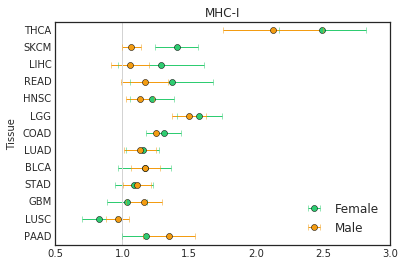

In [9]:
pldf = I
cat = 'Gender'
cat_name1 = 'Female'
cat_name2 = 'Male'
ordered_tissues = (pldf[pldf[cat] == cat_name1].OR - pldf[pldf[cat] == cat_name2].OR).sort_values(ascending=False).index
pldf = pldf.ix[ordered_tissues]
plt.axvline(1, color='lightgrey')
plt.errorbar(pldf[pldf[cat] == cat_name1].OR, range(len(pldf[pldf[cat] == cat_name1]))[::-1], 
             xerr=list(pldf[pldf[cat] == cat_name1].Error), fmt='o', 
             color='#2ECC71', label=cat_name1)
plt.errorbar(pldf[pldf[cat] == cat_name2].OR, range(len(pldf[pldf[cat] == cat_name2]))[::-1], 
             xerr=list(pldf[pldf[cat] == cat_name2].Error), fmt='o', 
             color='#F39C12', label=cat_name2)
plt.yticks(range(len(pldf[pldf[cat] == cat_name2]))[::-1], list(pldf[pldf[cat] == cat_name2].Tissue))
plt.ylabel('Tissue')
plt.ylim(-0.5, len(pldf[pldf[cat] == cat_name2])-0.5)
plt.title('MHC-I')
plt.legend(loc=4)
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/sex/OR.tissue.MHCI.pdf')

In [12]:
(pldf[pldf[cat] == cat_name1].OR - pldf[pldf[cat] == cat_name2].OR)

THCA    0.370023
SKCM    0.339022
LIHC    0.229884
READ    0.199978
HNSC    0.089550
LGG     0.076914
COAD    0.055577
LUAD    0.019894
BLCA   -0.003849
STAD   -0.022643
GBM    -0.125523
LUSC   -0.142343
PAAD   -0.174398
Name: OR, dtype: float64

In [13]:
pldf[pldf[cat] == cat_name1].OR

THCA    2.493216
SKCM    1.405702
LIHC    1.286837
READ    1.367116
HNSC    1.219699
LGG     1.574992
COAD    1.307421
LUAD    1.152045
BLCA    1.165409
STAD    1.086885
GBM     1.035487
LUSC    0.822230
PAAD    1.174110
Name: OR, dtype: float64

In [11]:
ordered_tissues

Index([u'THCA', u'SKCM', u'LIHC', u'READ', u'HNSC', u'LGG', u'COAD', u'LUAD',
       u'BLCA', u'STAD', u'GBM', u'LUSC', u'PAAD'],
      dtype='object')

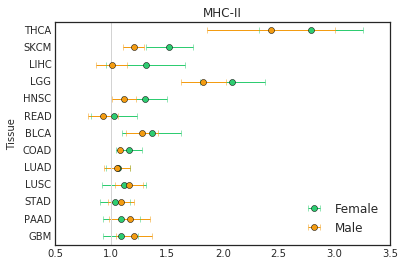

In [8]:
pldf = II
cat = 'Gender'
cat_name1 = 'Female'
cat_name2 = 'Male'
ordered_tissues = (pldf[pldf[cat] == cat_name1].OR - pldf[pldf[cat] == cat_name2].OR).sort_values(ascending=False).index
pldf = pldf.ix[ordered_tissues]
plt.axvline(1, color='lightgrey')
plt.errorbar(pldf[pldf[cat] == cat_name1].OR, range(len(pldf[pldf[cat] == cat_name1]))[::-1], 
             xerr=list(pldf[pldf[cat] == cat_name1].Error), fmt='o', 
             color='#2ECC71', label=cat_name1)
plt.errorbar(pldf[pldf[cat] == cat_name2].OR, range(len(pldf[pldf[cat] == cat_name2]))[::-1], 
             xerr=list(pldf[pldf[cat] == cat_name2].Error), fmt='o', 
             color='#F39C12', label=cat_name2)
plt.yticks(range(len(pldf[pldf[cat] == cat_name2]))[::-1], list(pldf[pldf[cat] == cat_name2].Tissue))
plt.ylabel('Tissue')
plt.ylim(-0.5, len(pldf[pldf[cat] == cat_name2])-0.5)
plt.title('MHC-II')
plt.legend(loc=4)
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/sex/OR.tissue.MHCII.pdf')

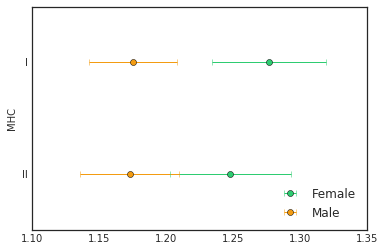

In [11]:
cat = 'Gender'
cat_name1 = 'Female'
cat_name2 = 'Male'

plt.errorbar(pan[pan[cat] == cat_name1].OR, range(len(pan[pan[cat] == cat_name1]))[::-1], 
             xerr=list(pan[pan[cat] == cat_name1].Error), fmt='o', 
             color='#2ECC71', label=cat_name1)
plt.errorbar(pan[pan[cat] == cat_name2].OR, range(len(pan[pan[cat] == cat_name2]))[::-1], 
             xerr=list(pan[pan[cat] == cat_name2].Error), fmt='o', 
             color='#F39C12', label=cat_name2)
plt.yticks([1, 0], list(pan[pan[cat] == cat_name2].Class))
plt.ylabel('MHC')
plt.ylim(-0.5, 1.5)
plt.legend(loc=4)
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/sex/OR.pan.pdf')

Combined results

In [ ]:
MI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.cancer.txt',
           sep= ' ')
FI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.class_i.female.txt',
           sep= ' ')
MI['Class'] = 'I'
FI['Class'] = 'I'
MI['Gender'] = 'Male'
FI['Gender'] = 'Female'

MII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.class_ii.male.txt',
           sep= ' ')
FII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.class_ii.female.txt',
           sep= ' ')
MII['Class'] = 'II'
FII['Class'] = 'II'
MII['Gender'] = 'Male'
FII['Gender'] = 'Female'

pan = pd.concat([MI, FI, MII, FII])
pan = pan.ix['mutation']